In [42]:
import xarray as xr
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import climlab.utils.thermo as clab
from climlab.utils.constants import ps, kappa, tempCtoK, eps, Rd, Rv, cpv, cp, g, Lhvap, sigma

In [43]:
# calculate the ELF

def Gammam(T,p):
    #  Gammam  = -dtheta/dz is the rate of potential temperature decrease along the moist adiabat
    #  in K / m
    Gammam_value = (g/cp*(1.0 - (1.0 + Lhvap*clab.qsat(T,p) / Rd / T) /
                   (1.0 + Lhvap**2 * clab.qsat(T,p)/ cp/Rv/T**2)))
    return Gammam_value

def ELF(T0,T700,Q0):

    # Lower Tropospheric Stability (theta700 - theta0)
    LTS = clab.potential_temperature(T700, 700) - T0
    # Assume 80% relative humidity to compute LCL, appropriate for marine boundary layer
    LCL = clab.lifting_condensation_level(T0, 0.8)
    p_LCL = 1000.0*np.exp(-g*LCL/Rd/T0)
    T_LCL = T0 - 9.8*LCL/1000.  # 9.8 K/km, dry adiabatic rate

    # Assuming z_ML = z_LCL
    Gammam_DL = Gammam(T_LCL,p_LCL)

    z700 = (Rd*T0/g)*np.log(1000./700.)
    Gammam700 = Gammam(T700,700)

    # Park and Shin (2019), Eqn 4
    d_zs = 2750 # scale height, m
    zinv = -(LTS/Gammam700) + z700 + d_zs*(Gammam_DL/Gammam700)
    
    beta2 = np.sqrt(zinv*LCL)/d_zs
#    f     = Q0.apply(lambda x: np.max([0.15, np.min([1.0, x/0.003])]))
    f     = ((Q0/0.003).clip(upper=1.0)).clip(lower=0.15)
    ELF   = f*np.sqrt(1-beta2)

    return ELF
    

In [62]:
dir_isccp='/glade/work/hpzhang/datasets/ISCCP/hgm/samples/*.nc'
f = xr.open_mfdataset(dir_isccp)

lat = f.lat
lon = f.lon

In [ ]:
dir_flx='/glade/work/hpzhang/datasets/MERRA2/monthly/flx/*.nc4'
dir_2d='/glade/work/hpzhang/datasets/MERRA2/monthly/2d/*.nc4'
dir_3d='/glade/work/hpzhang/datasets/MERRA2/monthly/3d/*.nc4'

f1 = xr.open_mfdataset(dir_flx)
f2 = xr.open_mfdataset(dir_2d)
f3 = xr.open_mfdataset(dir_3d)

def get_data(f1):
    f1 = f1.assign_coords(lon=f1.lon % 360)
    f1 = f1.sortby(f1.lon)
    f1 = f1.sel(time=slice('2015-01-01', '2017-06-30')).interp(lon=lon, lat=lat, kwargs={"fill_value": "extrapolate"})
    return f1

f1 = get_data(f1)
f2 = get_data(f2)
f3 = get_data(f3)

In [70]:
f4 = xr.open_dataset('~/work/LCC_pred/data/ERA5_SSF_monthly.nc')
f4 = f4.sel(time=slice('2015-01-01', '2017-06-30'))

In [90]:
f = f.sel(lat=slice(-60,60))
f1 = f1.sel(lat=slice(-60,60))
f2 = f2.sel(lat=slice(-60,60))
f3 = f3.sel(lat=slice(-60,60))
f4 = f4.sel(lat=slice(-60,60))

In [104]:
lat      = f['lat']
lon      = f['lon']
time     = f['time']
lsm      = f4['lsm']
LCF      = f['cldamt_irtypes'][:,0,:,:]/100. # unit, 1
T1000    = f3['T'].sel(lev = 1000)
T850     = f3['T'].sel(lev = 850)
T700     = f3['T'].sel(lev = 700)
TH1000   = T1000
TH850    = T850*(1000/850)**(0.286)
TH700    = T700*(1000/700)**(0.286)
RH1000   = f3['RH'].sel(lev = 1000)       # 1
RH850    = f3['RH'].sel(lev = 850)        # 1
RH700    = f3['RH'].sel(lev = 700)        # 1
Q1000    = f3['QV'].sel(lev = 1000)
Q850     = f3['QV'].sel(lev = 850)
Q700     = f3['QV'].sel(lev = 700)
U        = np.sqrt(f3['U']**2 + f3['V']**2)
U1000    = U.sel(lev = 1000)
U700     = U.sel(lev = 700)
OMEGA500 = f3['OMEGA'].sel(lev = 500)
OMEGA700 = f3['OMEGA'].sel(lev = 700)
PWV      = f2['TQV']   # kg m-2
SST      = f2['TS']
LH       = f1['EFLUX'] # W m-2 
SH       = f1['HFLUX'] # W m-2

u_wind = f3['U'].sel(lev = 1000)
v_wind = f3['V'].sel(lev = 1000)
Tadv   = mpcalc.advection(SST, u_wind, v_wind)

t_new, lat_new, lon_new = np.meshgrid(time, lat, lon, indexing='ij')

data = {'time':np.ndarray.flatten(t_new),
        'lat':np.ndarray.flatten(lat_new),
        'lon':np.ndarray.flatten(lon_new),
        'lsm':lsm.values.flatten(),
        'LCF': LCF.values.flatten(),          # 1
        'T1000':T1000.values.flatten(),       # K
        'T700':T700.values.flatten(),         # K
        'TH1000':TH1000.values.flatten(),     # K
        'TH850':TH850.values.flatten(),       # K
        'TH700':TH700.values.flatten(),       # K
        'RH1000':RH1000.values.flatten()*100, # %
        'RH850':RH850.values.flatten()*100,   # %
        'RH700':RH700.values.flatten()*100,   # %
        'Q1000':Q1000.values.flatten(),       # kg/kg
        'Q850':Q850.values.flatten(),         # kg/kg
        'Q700':Q700.values.flatten(),         # kg/kg
        'U1000':U1000.values.flatten(),       # m/s
        'U700':U700.values.flatten(),         # m/s
        'OMEGA500':OMEGA500.values.flatten(), # Pa/s
        'OMEGA700':OMEGA700.values.flatten(), # Pa/s
        'PWV':PWV.values.flatten(),           # kg/m2
        'LH':LH.values.flatten(),             # W/m2
        'SH':SH.values.flatten(),             # W/m2
        'SST':SST.values.flatten(),           # K
        'Tadv':Tadv.values.flatten()*3600*24, # K/day
       }

df = pd.DataFrame(data)
df = df.set_index('time')

df['dQ']    = df.Q1000 - df.Q700
df['LTS']   = df.TH700 - df.TH1000
df['EIS']   = clab.EIS(df.T1000, df.T700)
df['ECTEI'] = df.EIS - 0.23*Lhvap/cp*df.dQ
df['ELF']   = ELF(df.T1000, df.T700, df.Q1000)

/glade/work/hpzhang/tools/anaconda3/envs/geocat/lib/python3.9/site-packages/metpy/xarray.py:1471: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/glade/work/hpzhang/tools/anaconda3/envs/geocat/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [109]:
T1000.shape

(30, 120, 360)

In [112]:
df.dropna()

,lat,lon,lsm,LCF,T1000,T700,TH1000,TH850,TH700,RH1000,...,PWV,LH,SH,SST,Tadv,dQ,LTS,EIS,ECTEI,ELF
time,,,,,,,,,,,,,,,,,,,,,
2015-01-15,-57.5,185.5,0.000000,0.347,278.840076,267.023798,278.840076,285.748218,295.700411,91.242619,...,13.764486,37.256035,7.678333,279.691760,2.131936,0.003327,16.860336,7.858459,5.952882,0.896512
2015-01-15,-57.5,186.5,0.000000,0.347,278.717224,267.048395,278.717224,285.746102,295.727650,91.787162,...,13.794993,35.209435,6.740411,279.534290,0.614461,0.003289,17.010426,8.027330,6.143433,0.901038
2015-01-15,-57.5,187.5,0.000000,0.251,278.731018,267.052704,278.731018,285.749126,295.732422,92.208642,...,13.890139,38.487690,9.523148,279.708496,-0.121815,0.003308,17.001404,8.015066,6.120664,0.900662
2015-01-15,-57.5,188.5,0.000000,0.299,278.703821,267.030212,278.703821,285.729580,295.707515,91.930693,...,14.014632,39.893614,10.238674,279.726971,1.679476,0.003272,17.003694,8.025990,6.152043,0.901129
2015-01-15,-57.5,189.5,0.000000,0.299,278.565771,267.004694,278.565771,285.673717,295.679256,92.018661,...,14.111450,36.221612,7.393897,279.402631,3.528727,0.003227,17.113484,8.165390,6.317201,0.905335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-15,59.5,355.5,0.000000,0.320,283.901355,268.959631,283.901355,289.237124,297.844141,83.340175,...,18.832456,42.537708,3.209702,284.838879,0.301696,0.004171,13.942786,3.690018,1.301333,0.804198
2017-06-15,59.5,356.5,0.003876,0.300,283.939246,269.173633,283.939246,289.443302,298.081125,83.784881,...,19.343146,34.545497,1.287361,284.478729,1.772863,0.004084,14.141879,3.848089,1.509159,0.806481
2017-06-15,59.5,357.5,0.007309,0.300,283.924103,269.351624,283.924103,289.686270,298.278231,84.521347,...,19.692429,23.642794,-1.862954,283.975555,0.744439,0.004078,14.354128,4.034936,1.699634,0.809296


In [121]:
df = df[df.lsm == 0]
df.to_pickle("~/work/LCC_pred/data/data_monthly_merra2.pkl")
#df.to_csv("~/work/AOSC647/data/data_monthly.csv")
#df = df.drop(columns=['lat', 'lon', 'lsm', 'T1000', 'T700'])

In [119]:
PS0  = LCF.where(lsm<=0.05)[0,:,:]
lat0 = lat
lon0 = lon

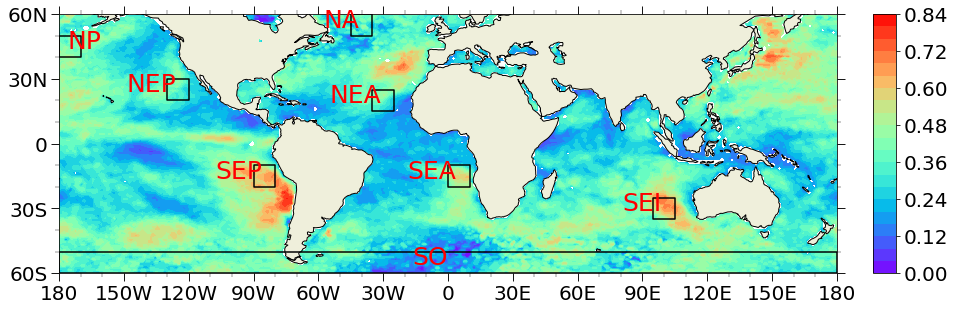

In [120]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm
import cartopy.feature as cfeature
import geocat.viz.util as gvutil
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

LCF_mean_cyc, lon_cyc = add_cyclic_point(PS0, coord=lon0)

fig = plt.figure(figsize=(15, 15))

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.7,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.5,
                cbar_size='3%',
                label_mode=''
                )  # note the empty label_mode

def get_box(lon, lat):
    lons = [lon[0], lon[1], lon[1], lon[0]]
    lats = [lat[0], lat[0], lat[1], lat[1]]
    ring = LinearRing(list(zip(lons, lats)))
    return(ring)

ring1 = get_box([-90,-80], [-20, -10]) # Peruvian
ring2 = get_box([0, 10], [-20, -10])   # Namibian
ring3 = get_box([-130,-120], [20, 30]) # Californian
ring4 = get_box([95,105], [-35,-25])   # Australian
ring5 = get_box([-35, -25], [15, 25])  # Canarian

ring6 = get_box([-180,-170], [40,50])  # North Pacific
ring7 = get_box([-45,-35], [50,60])    # North Atlantic
ring8 = get_box([-180,180], [-60,-50]) # Circumpolar Ocean

ring  = [ring1, ring2, ring3, ring4, ring5, ring6, ring7, ring8]
texts = ['SEP', 'SEA', 'NEP', 'SEI', 'NEA', 'NP', 'NA', 'SO']

#clev = np.arange(0, 1.0, 0.02)

for i, ax in enumerate(axgr):

    p = ax.contourf(lon_cyc, lat0, LCF_mean_cyc, 20, cmap=plt.cm.rainbow, transform=projection)

    ax.coastlines()
    ax.add_feature(cfeature.LAND)

    gvutil.add_major_minor_ticks(ax, labelsize=20)

    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    gvutil.add_lat_lon_ticklabels(ax, zero_direction_label=False)
    
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
    
    # plot boxes
    for i, ir in enumerate(ring):
        ax.add_geometries([ir], crs=projection, facecolor='none', edgecolor='black', lw=1.5)
        ha = 'left' if i==5 else 'right'
        x0 = 0 if i==7 else np.mean(ir.xy[0])
        ax.annotate(texts[i], xy=(x0, np.mean(ir.xy[1])), fontsize=25, c='red', ha = ha)

cax = axgr.cbar_axes[0]
cax.colorbar(p)
axis = cax.axis[cax.orientation]
axis.label.set_text(r'')
axis.label.set_size(22)
axis.major_ticklabels.set_size(20)